# big voxel gradients

In [2]:
import matplotlib.pyplot as plt
from brainspace.gradient import GradientMaps
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels
from hurst import compute_Hc
import math
import matplotlib.pyplot as plt
from neuromaps import images
import nibabel as nb
import numpy as np
import seaborn as sns

In [17]:
def get_ts(img):
    
    new_mat = []

    for tr in range(len(img.darrays)):
        signal = img.darrays[tr].data
        new_mat.append(np.squeeze(signal))

    new_mat = np.stack(new_mat)

    return new_mat # should be a ntr x nvtx matrix


def get_rMSSD(ts_mtx):
    out = np.zeros((ts_mtx.shape[0] - 1, ts_mtx.shape[1]))
    rMSSD = np.zeros(ts_mtx.shape[1])
    
    for lab in range(ts_mtx.shape[1]):
        for t in range(ts_mtx.shape[0] - 1):
            out[t,lab] = (ts_mtx[(t + 1), lab] - ts_mtx[t, lab])**2
        rMSSD[lab] = math.sqrt(np.mean(out[:,lab], axis = 0))
    
    return rMSSD 

def get_hurst(ts_mtx):
    hexp = np.zeros((ts_mtx.shape[1]))
    
    for lab in range(ts_mtx.shape[1]):
        H, c, data = compute_Hc(ts_mtx[:,lab], simplified=True)
        hexp[lab] = H
    
    return hexp

timeseries mapped trilinear / nn to fsnative surface from anat

*****5mm; 208ms; 1800trs
*****6mm; 170ms; 2200trs

use nearest neighbour - don't interpolate anything just to inspect

load timeseries

In [4]:
reso="6mm"
datapath = '/mica/mica1/03_projects/yigu/bigvoxel/data/use/'
scans = {'L': f'sub-PNC022_ses-05_{reso}-SE_hemi-L_enclos.func.gii',\
         'R': f'sub-PNC022_ses-05_{reso}-SE_hemi-R_enclos.func.gii'}

timeseries = {}; ts_mat = {}
print(scans['L']); print(scans['R'])

sub-PNC022_ses-05_6mm-SE_hemi-L_enclos.func.gii
sub-PNC022_ses-05_6mm-SE_hemi-R_enclos.func.gii


In [5]:
timeseries['L'] = nb.load(datapath + scans['L']); timeseries['R'] = nb.load(datapath + scans['R'])
ts_mat['L'] = get_ts(timeseries['L']); ts_mat['R'] = get_ts(timeseries['R'])
del timeseries

wb_mat = np.concatenate([ts_mat['L'], ts_mat['R']], axis = 1) # concatenate left and right by row
ntr, nvtx = wb_mat.shape
del ts_mat

ntr, nvtx

(2200, 204717)

connectivity: will take a long time, should parcellate.

arrange parcellation

In [6]:
annotpath = '/mica/mica1/03_projects/yigu/bigvoxel/derivatives/fastsurfer/sub-PNC022_ses-05/label/'
schaefer400 = {'L': 'lh.schaefer-400_mics.annot',
               'R': 'rh.schaefer-400_mics.annot'}
parcellation = images.annot_to_gifti((annotpath + schaefer400['L'], annotpath + schaefer400['R']))
nparc = len(parcellation[0].labeltable.labels) + len(parcellation[1].labeltable.labels)
parc_colors = np.zeros((nparc, len('rgba'))) # as many colors as there are parcels


In [8]:
# merge left and right color table
for p in range(nparc//2):
    parc_colors[p,] = parcellation[0].labeltable.labels[p].rgba
for p in range(nparc//2, nparc):
    parc_colors[p,] = parcellation[1].labeltable.labels[p - nparc//2].rgba

# merge left and right color mapping
labeling = np.concatenate([parcellation[0].darrays[0].data, parcellation[1].darrays[0].data], dtype = int)
colors = np.zeros((nvtx, len('rgba'))) # as many colors as there are vertices
for i in range(nvtx):
            
    colors[i,:] = parc_colors[labeling[i]] # colors for the scatter plot

parcellate

In [10]:
parc_data = np.zeros((ntr, nparc - 2))

for parc in range(nparc - 2):
    idx = np.where(labeling==parc)
    subset = wb_mat[:,idx[0]]
    if idx[0].shape == (0,): print(parc)
    
    parc_data[:, parc] = np.mean(subset, axis = 1)

plot parcellated timeseries

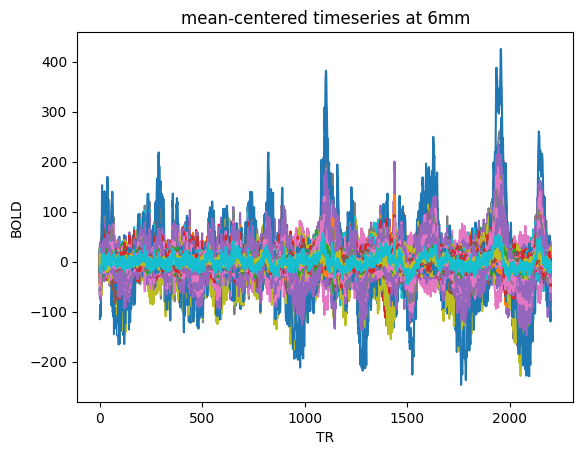

In [11]:
plt.plot(parc_data)
plt.xlabel('TR')
plt.ylabel('BOLD')
plt.title(f'mean-centered timeseries at {reso}')
plt.show()

correlation on parcellated data - it's okay it's coarse sampling anyways

In [12]:
fc = np.corrcoef(parc_data.T) # symmetrical matrix
np.save(datapath + f'{reso}-SE_schaefer400_fc.npy', fc)
print(fc.shape)

(400, 400)


plotting

<Axes: >

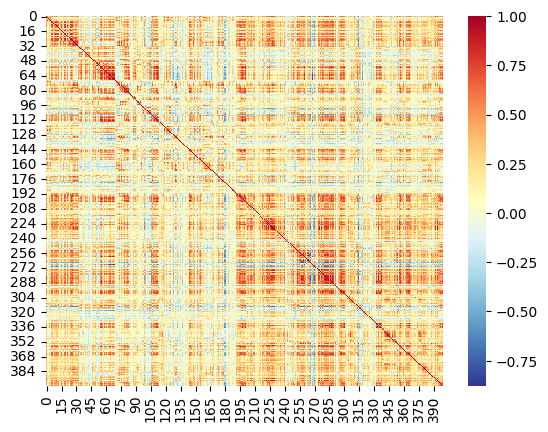

In [13]:
sns.heatmap(fc, cmap='RdYlBu_r')

In [ ]:
#wdc = np.mean(fc, axis=1)
#sd = np.std(wb_mat, axis=0)
#rmssd = get_rMSSD(wb_mat)
hexp = get_hurst(wb_mat)
print(hexp.shape)

weighted node strengths

In [ ]:
surfaces = '/mica/mica1/03_projects/yigu/bigvoxel/derivatives/micapipe_v0.2.0/sub-PNC022/ses-05/surf/'
figs = '/mica/mica1/03_projects/yigu/bigvoxel/results/'
# hemispheres

surfs = {}
surfs['L'] = read_surface(surfaces + 'sub-PNC022_ses-05_hemi-L_space-nativepro_surf-fsnative_label-pial.surf.gii')
surfs['R'] = read_surface(surfaces + 'sub-PNC022_ses-05_hemi-R_space-nativepro_surf-fsnative_label-pial.surf.gii')

mask = labeling != 0
metrics_to_plot = [map_to_labels(wdc, labeling, mask=mask, fill=np.nan), \
                   map_to_labels(sd, labeling, mask=mask, fill=np.nan), \
                   map_to_labels(rmssd, labeling, mask=mask, fill=np.nan), \
                    map_to_labels(hexp, labeling, mask=mask, fill=np.nan)]

plot_hemispheres(surfs['L'], surfs['R'], array_name = metrics_to_plot , size = (1200, 400), \
                 cmap='RdYlBu_r', color_bar = 'right', \
                zoom=1.3, embed_nb=True, \
                transparent_bg=True, offscreen=False)


In [ ]:
gm = GradientMaps(n_components=10)
gm.fit(fc)

In [ ]:
grad = [None] * 3

for i in range(3):
    grad[i] = map_to_labels(gm.gradients_[:, i], labeling, mask=mask, fill=np.nan)

plot_hemispheres(surfs['L'], surfs['R'], array_name = grad, size = (1200, 400), cmap = 'viridis_r', \
               color_bar = True, label_text = ['g1', 'g2', 'g3'], zoom=1.3, \
                embed_nb=True, transparent_bg=True, offscreen=False)

In [ ]:
# scatter plot in "gradient space"
g1=grad[0]; g2=grad[1]; g3=grad[2]

fig = plt.figure(figsize=(14, 14))
ax = plt.subplot(projection ="3d")
# color by networks
ax.scatter3D(xs=g1, ys=g2, zs=g3, c = colors)
ax.set_xlabel('g1'); ax.set_ylabel('g2'); ax.set_zlabel('g3')
plt.title('FC 6mm big voxel')
plt.show()
#plt.close()
#fig.savefig(figs + '5mm-SE_fc-grad_scatter_pca.png')

In [ ]:
plt.plot(range(gm.lambdas_.size), gm.lambdas_, '--bo')
plt.xlabel('component')
plt.ylabel('eigenvalue')